In [1]:
from pystac_client import Client

In [2]:
catalog = Client.open('https://earth-search.aws.element84.com/v1/')
catalog

<Client id=earth-search-aws>

In [5]:
aoi = '''
{
        "coordinates": [
          [
            [
              -0.5755148001526891,
              5.848533660012109
            ],
            [
              -0.5755148001526891,
              5.4565614670548115
            ],
            [
              0.17058042195941425,
              5.4565614670548115
            ],
            [
              0.17058042195941425,
              5.848533660012109
            ],
            [
              -0.5755148001526891,
              5.848533660012109
            ]
          ]
        ],
        "type": "Polygon"
      }
''' 

In [12]:
results = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    intersects=aoi,
    datetime=['2024-06-01', '2024-08-31'],
    query=['eo:cloud_cover<50'],
    sortby='properties.datetime',
)

In [13]:
results.matched()

9

In [14]:
items = results.item_collection()
items

In [18]:
import geopandas

In [20]:
gdf = geopandas.GeoDataFrame.from_features(items, crs="epsg:4326")

In [22]:
gdf.explore()

In [15]:
import stackstac

In [16]:
stack = stackstac.stack(items, assets=['red', 'green', 'blue'])

In [17]:
stack

<xarray.DataArray 'stackstac-04dad99fff5aeae9dc2e22f31bf28f7c' (time: 9,
                                                                band: 3,
                                                                y: 10980,
                                                                x: 20982)> Size: 50GB
dask.array<fetch_raster_window, shape=(9, 3, 10980, 20982), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/56)
  * time                                     (time) datetime64[ns] 72B 2024-0...
    id                                       (time) <U30 1kB 'S2B_T30NZM_2024...
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
  * x                                        (x) float64 168kB 7e+05 ... 9.09...
  * y                                        (y) float64 88kB 7e+05 ... 5.902...
    view:sun_azimuth                         (time) float64 72B 46.56 ... 69.65
    ...                                       ...
    gsd                                      int64 8B 10
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(699960.0, 590220.0, 909780.0,...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 700020.00|\n| 0.00...
    resolution:  10.0

In [23]:
lon, lat = -0.20462040112030877, 5.5506143256639575

In [24]:
import pyproj

In [25]:
x, y = pyproj.Proj(stack.crs)(lon, lat)

In [26]:
x, y

(809728.3727654959, 614260.1499340455)

In [27]:
buffer = 2000

In [28]:
area = stack.loc[..., y+buffer:y-buffer, x-buffer:x+buffer]
area

<xarray.DataArray 'stackstac-04dad99fff5aeae9dc2e22f31bf28f7c' (time: 9,
                                                                band: 3,
                                                                y: 400, x: 400)> Size: 35MB
dask.array<getitem, shape=(9, 3, 400, 400), dtype=float64, chunksize=(1, 1, 400, 400), chunktype=numpy.ndarray>
Coordinates: (12/56)
  * time                                     (time) datetime64[ns] 72B 2024-0...
    id                                       (time) <U30 1kB 'S2B_T30NZM_2024...
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
  * x                                        (x) float64 3kB 8.077e+05 ... 8....
  * y                                        (y) float64 3kB 6.163e+05 ... 6....
    view:sun_azimuth                         (time) float64 72B 46.56 ... 69.65
    ...                                       ...
    gsd                                      int64 8B 10
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(699960.0, 590220.0, 909780.0,...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 700020.00|\n| 0.00...
    resolution:  10.0

In [29]:
data = area.compute()

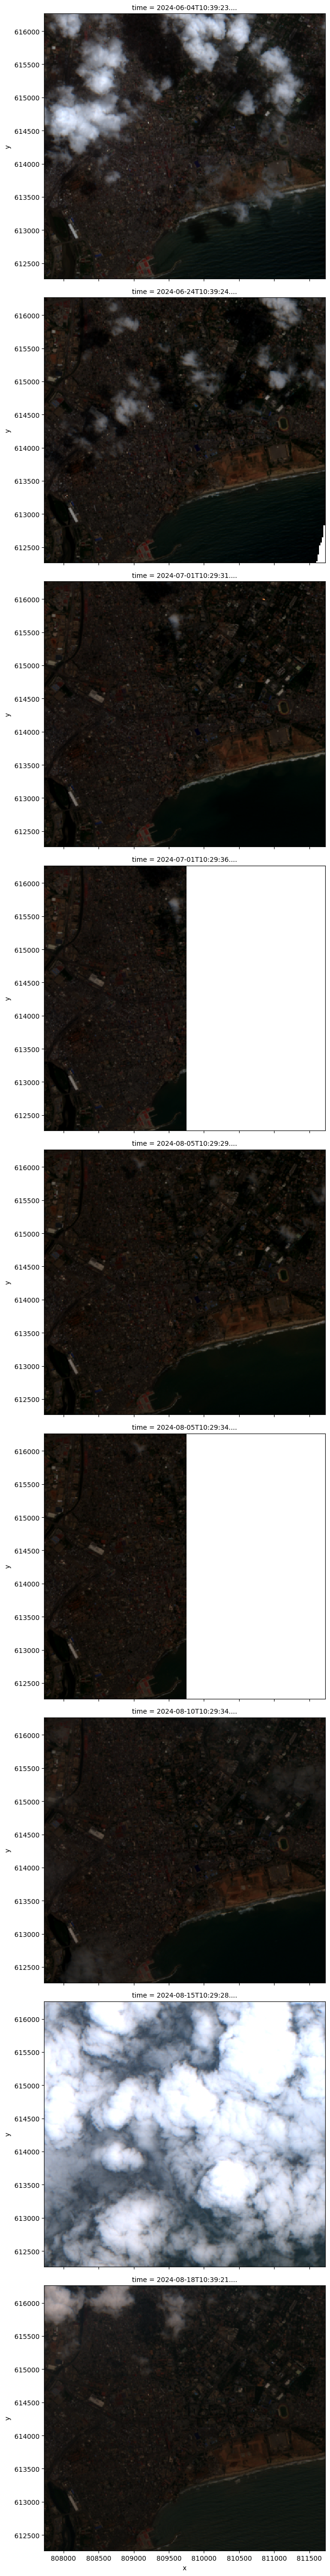

In [30]:
data.plot.imshow(row='time', rgb='band', robust=True, size=6)

In [31]:
median = area.median(dim="time", keep_attrs=True)

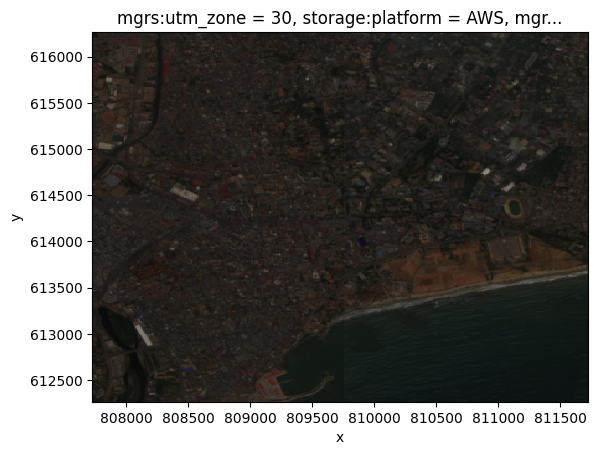

In [32]:
median.plot.imshow()